# Vinícius Prates Rodrigues - 2017023005

Link para apresentação do trabalho: https://youtu.be/wIabkLa1nQY

In [ ]:
!pip install emoji

     |████████████████████████████████| 174 kB 5.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=8ce2e09cf9ccb708e526c1090712a8541a981a462af9048ef3ece8c128373c36
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import emoji
import re, string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(rc={'figure.figsize':(11, 4)})
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def pre_process(text):
    text = text.replace('\r', '').replace('\n', ' ').lower()
    text = re.sub(emoji.get_emoji_regexp(), r"", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text


In [ ]:
data = pd.read_csv("cyberbullying_tweets.csv").rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'type'}).drop_duplicates()
data['clean_text'] = data.apply(lambda row: pre_process(row['text']), axis=1)
data['simple_type'] = (data['type'] != 'not_cyberbullying').astype(str)
data.head()

,text,type,clean_text,simple_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr,False
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,False
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes,False
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thanks heads concerned another angry dud...,False
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account like i...,False


In [ ]:
data = data[data['type'] != "other_cyberbullying"]

In [ ]:
NUM_TAGS = len(data['type'].unique())

print(f"Data shape: {data.shape}")
print(f"Tags: {data['type'].unique()}")

Data shape: (39833, 4)
Tags: ['not_cyberbullying' 'gender' 'religion' 'age' 'ethnicity']


In [ ]:
X = data['clean_text'].values
Y = data['type'].values

print(X)
print(Y)

['words katandandre food crapilicious mkr'
 'aussietv white mkr theblock imacelebrityau today sunrise studio10 neighbours wonderlandten etc'
 'classy whore red velvet cupcakes' ...
 'swear god dumb nigger bitch got bleach hair reeeeeal fuckin soon dlt fuck'
 'yea fuck rt youre nigger fucking unfollow fucking dumb niggers'
 'bro u gotta chill rt dog fuck kp dumb nigger bitch lmao']
['not_cyberbullying' 'not_cyberbullying' 'not_cyberbullying' ...
 'ethnicity' 'ethnicity' 'ethnicity']


In [ ]:
lengths = [len(sentence.split()) for sentence in data['text'].values]

print(f"95% dos tweets tem tamanho menor ou igual a {np.percentile(lengths, 95)}")

95% dos tweets tem tamanho menor ou igual a 51.0


In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

print(f"Original: {X[0]}")
print(f"Encoded: {X_encoded[0]}")

Original: words katandandre food crapilicious mkr
Encoded: [322, 2157, 631, 19036, 26]


In [ ]:
tag_tokenizer = Tokenizer(filters='')
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

print(f"Original: {Y[0]}")
print(f"Encoded: {Y_encoded[0]}")

Original: not_cyberbullying
Encoded: [5]


In [ ]:
tag_tokenizer.word_index

{'age': 2, 'ethnicity': 3, 'gender': 4, 'not_cyberbullying': 5, 'religion': 1}

In [ ]:
MAX_SEQ_LENGTH = 50

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
X = X_padded
print(f"X shape after padding:{X.shape}")

X shape after padding:(39833, 50)


In [ ]:
Y = to_categorical(np.array(Y_encoded) - 1) # subtrai 1 para o array ficar de 0 a 5
Y.shape

(39833, 5)

In [ ]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

print(f"Train:\nX shape:{X_train.shape} Y shape:{Y_train.shape}")
print(f"Test:\nX shape:{X_test.shape} Y shape:{Y_test.shape}")

Train:
X shape:(33858, 50) Y shape:(33858, 5)
Test:
X shape:(5975, 50) Y shape:(5975, 5)


In [ ]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1 # precisa adicionar + 1 para englobar o "0", que representa o padding
NUM_CLASSES = NUM_TAGS
EMBEDDING_SIZE = 300

lstm_model = Sequential()

# Layer de Embedding. Produz os Word Embeddings das palavras
lstm_model.add(Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_SIZE, input_length=MAX_SEQ_LENGTH, trainable=True))

# Layer Bidirecional de LSTMs, com tamanho do hidden state igual a 128. 
lstm_model.add(Bidirectional(LSTM(64)))

# Layer Fully Connected com tamanho igual ao número de classes, com uma ativação de softmax. Produz como saída uma probabilidade para cada classe
lstm_model.add(Dense(NUM_CLASSES, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'Recall'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           13759200  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 13,946,725
Trainable params: 13,946,725
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='val_acc', restore_best_weights=True)
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_split=0.15, callbacks=[callback])

Epoch 1/10
225/225 [==============================] - 105s 446ms/step - loss: 0.4967 - acc: 0.8275 - recall: 0.7261 - val_loss: 0.1927 - val_acc: 0.9405 - val_recall: 0.9350
Epoch 2/10
225/225 [==============================] - 111s 492ms/step - loss: 0.1332 - acc: 0.9548 - recall: 0.9522 - val_loss: 0.2052 - val_acc: 0.9358 - val_recall: 0.9335


In [ ]:
loss, accuracy, recall = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print(f"Loss: {loss}\nAccuracy: {accuracy}\nRecall: {recall}")

187/187 [==============================] - 5s 25ms/step - loss: 0.2161 - acc: 0.9244 - recall: 0.9192
Loss: 0.21609510481357574
Accuracy: 0.9243514537811279
Recall: 0.919163167476654


In [ ]:
predictions = lstm_model.predict(X_test)
print(f"Predictions shape: {predictions.shape}")
print(f"Labels shape: {Y_test.shape}")

Predictions shape: (5975, 5)
Labels shape: (5975, 5)


In [ ]:
predictions = np.argmax(predictions, axis=1) # soma 1 para sair do intervalo [0, 5] para o intervalo [1, 6] original
labels = np.argmax(Y_test, axis=1) # mesma coisa aqui
print(f"Prediction: {predictions[0]}")
print(f"Label: {labels[0]}")

Prediction: 0
Label: 0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1183
           1       0.98      0.97      0.98      1199
           2       0.98      0.99      0.98      1167
           3       0.93      0.85      0.89      1251
           4       0.79      0.88      0.83      1175

    accuracy                           0.92      5975
   macro avg       0.93      0.93      0.93      5975
weighted avg       0.93      0.92      0.93      5975

[[1111    2    7    4   59]
 [   2 1168    3    2   24]
 [   0    0 1151    2   14]
 [   6    0    5 1064  176]
 [  39   17   14   76 1029]]


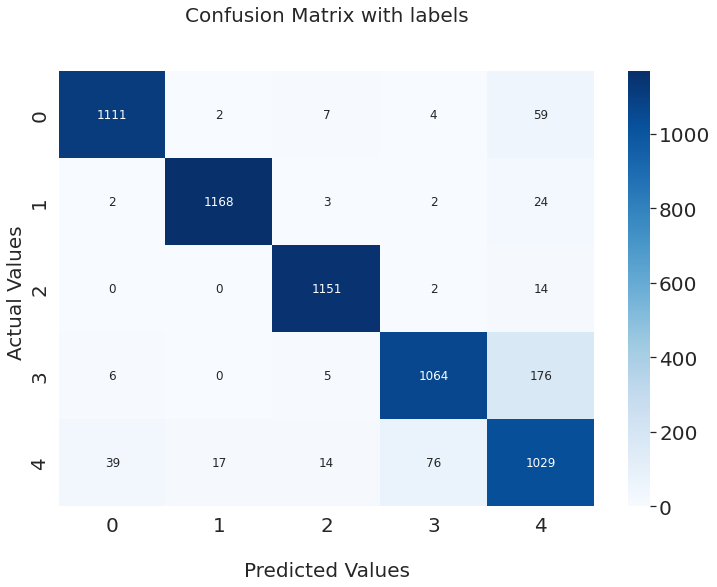

In [ ]:
cf_matrix = confusion_matrix(labels, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

In [ ]:
pred_df = pd.DataFrame({'label': labels, 'prediction': predictions})
pred_df['hit'] = (pred_df['label'] == pred_df['prediction']).astype(int)

percentage = pred_df.groupby('label').count()['prediction'] / len(pred_df)

results = pred_df[['label', 'hit']].groupby('label').mean().join(percentage).sort_values(by='label')
results.columns = ['accuracy', 'presence_in_data']

tag_name_map = {value-1 : key for (key, value) in tag_tokenizer.word_index.items()}
tag_name_map = pd.DataFrame.from_dict(tag_name_map, orient='index', columns=['tag_name'])

results = results.join(tag_name_map)
results[['accuracy', 'tag_name']]

,accuracy,tag_name
label,,
0,0.939138,religion
1,0.974145,age
2,0.986290,ethnicity
3,0.850520,gender
4,0.875745,not_cyberbullying
